In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.vocab import Vocab
from spacy.pipeline import EntityRuler
from spacy.util import minibatch, compounding

import os
import shutil
import random
from google.colab import drive

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
spacy.__version__

'2.2.4'

In [3]:
drive.mount('/content/drive', force_remount=True)
os.chdir("drive/My Drive/glean_data")

Mounted at /content/drive


## read and understand the data

In [4]:
df = pd.read_excel('question-python-data-science-project-mwsr7tgbeo-mapping_challenge.xlsx',
                   sheet_name = ['train', 'eval', 'canonical_line_item_table']
                  )

In [5]:
train_df = df['train']
eval_df = df['eval']
df_labels = df['canonical_line_item_table']
del df

In [293]:
train_df.sample(5)

,line_item_name,line_item_description,canonical_vendor_name,canonical_line_item_name
108,Credit for remaining Organization Annual 15,NaN,Asana,Organization Annual
215,FOREIGN FILING IN MARYLAND,2019 APRIL RENEWALS,CSC,FOREIGN FILING
64,"USB C Charger, Nekteck 90W Type C Wall Charger...",NaN,Amazon Business,"USB C Charger, Nekteck 90W Type C Wall Charger..."
556,Filing Fees,Submit DBA name registration to New York Secre...,Westmont Associates,Expenses: Filing Fees
169,PROFESSIONAL SERVICES,Correspondence with client regarding use of pr...,Cooper & Dunham,Hourly Services: LAA


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   line_item_name            659 non-null    object
 1   line_item_description     469 non-null    object
 2   canonical_vendor_name     659 non-null    object
 3   canonical_line_item_name  659 non-null    object
dtypes: object(4)
memory usage: 20.7+ KB


In [ ]:
eval_df.head()

,line_item_name,line_item_description,canonical_vendor_name,canonical_line_item_name
0,Management Services,May 2019 Services,10 Minute Ventures,NaN
1,Acrobat Pro DC,NaN,Adobe,NaN
2,AIEX 96 Pieces Adhesive Poster Tacky Putty Sti...,NaN,Amazon Business,NaN
3,AmazonBasics AAA 1.5 Volt Performance Alkaline...,NaN,Amazon Business,NaN
4,AmazonBasics Mesh Trash Can Waste Basket,1,Amazon Business,NaN


In [ ]:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   line_item_name            337 non-null    object 
 1   line_item_description     239 non-null    object 
 2   canonical_vendor_name     337 non-null    object 
 3   canonical_line_item_name  0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 10.7+ KB


In [207]:
eval_df.drop_duplicates()

,line_item_name,line_item_description,canonical_vendor_name,canonical_line_item_name
0,Management Services,May 2019 Services,10 Minute Ventures,NaN
1,Acrobat Pro DC,NaN,Adobe,NaN
2,AIEX 96 Pieces Adhesive Poster Tacky Putty Sti...,NaN,Amazon Business,NaN
3,AmazonBasics AAA 1.5 Volt Performance Alkaline...,NaN,Amazon Business,NaN
4,AmazonBasics Mesh Trash Can Waste Basket,1,Amazon Business,NaN
...,...,...,...,...
332,Web,1. Thimble Monthly Webapp 2. Customer Referral...,Xiamen ZhiZhi Tech,NaN
333,Sam Web,1. Web app 2.0 mobile version 2. Purchase wid...,Xiamen ZhiZhi Tech,NaN
334,Sam Web,1. Segment Integration 2. Iterable Integration,Xiamen ZhiZhi Tech,NaN
335,Sam Web,1. Broker Purchase Project 2. New Insurance Pr...,Xiamen ZhiZhi Tech,NaN


In [ ]:
df_labels.canonical_line_item_name.value_counts()[:10]

Expenses                                                                                                                 4
Hourly Services: BYH                                                                                                     2
Filing Fees                                                                                                              2
Marketing Services                                                                                                       2
Blog Post                                                                                                                2
Sales Tax                                                                                                                2
Hourly Services                                                                                                          2
Yealink CP960 Conference IP Phone, 5-Inch Color Touch Screen. 802.11ac Wi-Fi, 802.3af PoE, Power Adapter Not Included    1
96" Power Entry 

We see that there are a few labels that are duplicated, but this shouldn't matter since they will fall into different candidates

In [132]:
df_labels = df_labels.drop_duplicates() #one row was fully duplicated

In [7]:
# make sure that the target values in train all appear as candidates in canonical line item table

for i,row in train_df.iterrows():
    candidates = df_labels[df_labels.canonical_vendor_name == row.canonical_vendor_name]
    assert (candidates.canonical_line_item_name.eq(row.canonical_line_item_name)).any()
      
for i,row in eval_df.iterrows():
    assert((df_labels.canonical_vendor_name.eq(row.canonical_vendor_name)).any())

I notice that many of the canonical line item names are very similar to either the vendor or raw item name. This should be helpful during training.

I also notice many null desciptions, but there's little to do about it in a small dataset

## Create Knowledge base

In [133]:
nlp = spacy.load('en_core_web_sm')
from spacy.kb import KnowledgeBase
kb = KnowledgeBase(vocab=nlp.vocab, entity_vector_length=96)

Right now as there is such small data, makes sense to train only on vendors that have more than one line items. And then manually predict vendors with just one.

In [134]:

c = df_labels.canonical_vendor_name.value_counts() 
one_or_less = list(c[c <= 1].index)
two_or_more = list(c[c > 1].index)
NAME = two_or_more

The entities are all the `canonical_line_item_name`'s with the alias being the vendor name. So half the task is already done for us! We already have the entity(the vendor), and the goal of my task is to find out which candidate is the right one. 

In [135]:

def add_ents_and_aliases():
  
  ids = []
  for name in NAME:
      ents = df_labels[df_labels.canonical_vendor_name == name]
      for i, row in ents.iterrows():
          doc = nlp(name + ' : ' +row.canonical_line_item_name)
          #print(doc)
          vec = doc.vector
          kb.add_entity(entity=str(row.name), entity_vector=vec, freq=300)
          ids.append(str(row.name))

      kb.add_alias(alias=name, entities=ids, probabilities=np.full((len(ids),), 1/len(ids)))
      ids.clear()
add_ents_and_aliases()

## Generate training data

Combine the title and description into one string and will later use spaCy's embedding model to embed them. The target variable is simply the row index of the `canonical_line_item_name`

In [211]:
def format_data(NAME, df):
    data = []
    for i, row in df[df.canonical_vendor_name.isin(NAME)].iterrows():
        desc = str(row.line_item_description) if not row.line_item_description is np.nan else ''
        text = row.canonical_vendor_name + ' : ' + str(row.line_item_name) + ' : '+ desc
        cands = df_labels[df_labels.canonical_vendor_name == row.canonical_vendor_name]
        name = cands[cands.canonical_line_item_name == row.canonical_line_item_name]
        assert(name.shape[0] == 1)
    
        label = str(name.index[0])
        offset = (0, len(row.canonical_vendor_name))
        links_dict = {label: 1.0}
        data.append((text, {"links": {offset: links_dict}}))
        
    return data

In [137]:
train_data = format_data(NAME, train_df)

In [195]:
len(train_data)

596

In [15]:
train_data[0]

('Amazon Business : [100 Pack] 10 oz. White Paper Hot Cups - Coffee Cups : ',
 {'links': {(0, 15): {'26': 1.0}}})

In [99]:
def get_gold_ids(train_data):
  gold_ids = []
  for text, annot in train_data:
      for span, links_dict in annot["links"].items():
          for link, value in links_dict.items():
              if value:
                  gold_ids.append(link)

  from collections import Counter
  print(Counter(gold_ids))
  return gold_ids

In [197]:
def train_test_split(train_data, gold_ids, SPLIT_NUM, shuffle=False):
  train_dataset = []
  test_dataset = []
  for QID in [str(i) for i in range(544)]:
      indices = [k for k, j in enumerate(gold_ids) if j == QID]
      #if len(indices) > 0: print(QID,len(indices), indices)
      if len(indices) > SPLIT_NUM:
        if shuffle:
          np.random.shuffle(indices)
        train_dataset.extend(train_data[index] for index in indices[:SPLIT_NUM])  
        test_dataset.extend(train_data[index] for index in indices[SPLIT_NUM:])  
      else:
        train_dataset.extend(train_data[index] for index in indices)

  return train_dataset, test_dataset
  

In [198]:
gold_ids = get_gold_ids(train_data)
train_dataset, test_dataset = train_test_split(train_data,gold_ids,6)

Counter({'4': 24, '411': 19, '5': 18, '3': 17, '243': 16, '429': 15, '406': 13, '6': 11, '246': 10, '248': 10, '281': 9, '470': 8, '244': 7, '478': 7, '290': 7, '365': 7, '228': 6, '272': 6, '469': 5, '405': 5, '431': 5, '220': 4, '301': 4, '306': 4, '392': 4, '366': 4, '42': 3, '477': 3, '484': 3, '491': 3, '168': 3, '175': 3, '247': 3, '250': 3, '302': 3, '513': 3, '320': 3, '315': 3, '341': 3, '409': 3, '420': 3, '434': 3, '440': 3, '435': 3, '432': 3, '449': 3, '444': 3, '104': 2, '20': 2, '505': 2, '488': 2, '502': 2, '152': 2, '154': 2, '200': 2, '7': 2, '209': 2, '212': 2, '219': 2, '224': 2, '479': 2, '270': 2, '273': 2, '276': 2, '294': 2, '303': 2, '507': 2, '509': 2, '309': 2, '308': 2, '310': 2, '319': 2, '316': 2, '352': 2, '364': 2, '367': 2, '408': 2, '417': 2, '436': 2, '437': 2, '438': 2, '448': 2, '445': 2, '452': 1, '454': 1, '456': 1, '26': 1, '45': 1, '46': 1, '47': 1, '49': 1, '51': 1, '53': 1, '27': 1, '55': 1, '56': 1, '57': 1, '59': 1, '61': 1, '14': 1, '62': 1

We see that because the data is so small there are many `canonical_line_item_name`'s that appear only once in the train set which will make good predictions difficult. So the plan will be to make the smallest test dataset possible while still maintaining good metrics. Afterwards, I will train on the entire dataset and use that to predict the eval set.


In [199]:
len(train_dataset)


494

In [182]:
len(test_dataset)

102

## Build a NEL Model

#### Some of the code below setting up the model was based off a spaCy tutorial

In [183]:
print(f"Entities in the KB: {kb.get_entity_strings()}")
print(f"Aliases in the KB: {kb.get_alias_strings()}")

Entities in the KB: ['507', '533', '263', '390', '357', '277', '101', '22', '30', '541', '75', '120', '91', '346', '26', '86', '429', '251', '37', '532', '294', '385', '19', '359', '38', '71', '167', '55', '529', '54', '177', '540', '326', '258', '280', '196', '437', '504', '257', '466', '209', '151', '534', '187', '488', '90', '383', '432', '72', '13', '441', '181', '502', '409', '449', '382', '406', '331', '62', '252', '152', '516', '415', '206', '118', '290', '329', '52', '132', '57', '381', '463', '287', '344', '373', '306', '111', '125', '364', '260', '391', '127', '452', '519', '237', '160', '349', '319', '351', '149', '520', '464', '494', '163', '471', '521', '462', '27', '425', '222', '246', '248', '482', '272', '121', '245', '46', '455', '215', '107', '414', '225', '525', '508', '438', '15', '134', '230', '403', '210', '303', '453', '424', '14', '479', '73', '362', '7', '486', '308', '60', '205', '324', '18', '259', '49', '241', '85', '58', '193', '211', '451', '501', '444', '

In [22]:
def prepare_train(nlp_blank, train_dataset):
  kb_ids = nlp_blank.get_pipe("entity_linker").kb.get_entity_strings()
  TRAIN_DOCS = []
  for text, annotation in train_dataset:
      with nlp_blank.disable_pipes("entity_linker"):
          doc = nlp_blank(text)
      annotation_clean = annotation
      for offset, kb_id_dict in annotation["links"].items():
          new_dict = {}
          for kb_id, value in kb_id_dict.items():
              if kb_id in kb_ids:
                  new_dict[kb_id] = value
              else:
                  print(
                      "Removed", kb_id, "from training because it is not in the KB."
                  )
          annotation_clean["links"][offset] = new_dict
      TRAIN_DOCS.append((doc, annotation_clean))
  return TRAIN_DOCS

def build_model(kb, train_dataset, NAME):
  nlp_blank = spacy.blank("en", vocab=kb.vocab)
  nlp_blank.vocab.vectors.name = "spacy_pretrained_vectors"
  patterns = []
  for name in NAME:
    names = name.split(' ')
    vend = {"label": "VENDOR", "pattern": [{"LOWER": n.lower()} for n in names]}
    patterns.append(vend)
  
  ruler = EntityRuler(nlp_blank)
  ruler.add_patterns(patterns)
  nlp_blank.add_pipe(ruler)

  nlp_blank.add_pipe(nlp_blank.create_pipe('sentencizer'))
  if "entity_linker" not in nlp_blank.pipe_names:
      print('setting up')
      entity_linker = nlp_blank.create_pipe("entity_linker", config={"incl_prior": False})
      entity_linker.set_kb(kb)
      nlp_blank.add_pipe(entity_linker, last=True)
  train_dataset = prepare_train(nlp_blank, train_dataset)
  return nlp_blank, train_dataset


In [184]:

nlp_blank, train_dataset = build_model(kb, train_dataset, NAME)

setting up


In [177]:
def train(nlp_blank, TRAIN_DOCS, epochs, verbose=True):
  other_pipes = [pipe for pipe in nlp_blank.pipe_names if pipe != "entity_linker"]
  with nlp_blank.disable_pipes(*other_pipes):   # train only the entity_linker
      optimizer = nlp_blank.begin_training()
      for itn in range(epochs):   # 500 iterations takes about a minute to train
          np.random.shuffle(TRAIN_DOCS)
          batches = minibatch(TRAIN_DOCS, size=compounding(4.0, 32.0, 1.001))  # increasing batch sizes
          losses = {}
          for batch in batches:
              texts, annotations = zip(*batch)
              nlp_blank.update(
                  texts,  
                  annotations,   
                  drop=0.2,      # prevent overfitting
                  losses=losses,
                  sgd=optimizer,
              )
          #if itn % 1 == 0:
          if verbose:
            print(itn, "Losses", losses)   # print the training loss
          elif itn % 100 == 0:
            print(itn, "Losses", losses)   # print the training loss
  print(itn, "Losses", losses)

In [185]:
train(nlp_blank, train_dataset, epochs=600)

0 Losses {'entity_linker': 31.701195552945137}
1 Losses {'entity_linker': 21.304295271635056}
2 Losses {'entity_linker': 17.402195155620575}
3 Losses {'entity_linker': 14.864536583423615}
4 Losses {'entity_linker': 13.068447098135948}
5 Losses {'entity_linker': 11.634586438536644}
6 Losses {'entity_linker': 10.872650370001793}


KeyboardInterrupt: ignored

## Evaluate

In [150]:
from sklearn.metrics import confusion_matrix, accuracy_score,average_precision_score, f1_score, classification_report

In [106]:
def one_or_less_map(one_or_less):
  map_ = {}
  df = df_labels[df_labels.canonical_vendor_name.isin(one_or_less)]
  for i, row in df.iterrows():
    map_[row.canonical_vendor_name] = row.name
  return map_
  

In [188]:
def predict(model, test_dataset, df_orig=None, actual_exists=True):
  y_actual, y_pred, y_actual_ones, y_pred_ones = [], [], [], []
  if df_orig is not None: #as described before, this bit of code manually
                          #predicts any vendor that has just one canonical name
    ones = df_orig[df_orig.canonical_vendor_name.isin(one_or_less)]
    map_ = one_or_less_map(one_or_less)
    for i, row in ones.iterrows():
      pred = map_[row.canonical_vendor_name]
      if actual_exists:
        another = df_labels[(df_labels.canonical_vendor_name == 
        row.canonical_vendor_name) & (df_labels.canonical_line_item_name == 
                                      row.canonical_line_item_name)]         
        actual = another.index[0]
        y_actual_ones.append(actual)
      y_pred_ones.append(pred)
    

  for text, true_annot in test_dataset:
    doc = model(text) 
    for ent in doc.ents:
        if actual_exists:
          y_actual.append(list(list(true_annot['links'].values())[0].keys())[0])
        y_pred.append(ent.kb_id_)
  return y_actual, y_pred, y_actual_ones, y_pred_ones


In [95]:
y_actual, y_pred, y_actual_ones, y_pred_ones= predict(nlp_blank, test_dataset, train_df)
labes = list(set(y_actual+ y_pred))


In [107]:
def get_metrics(y_actual, y_pred):
  acc = accuracy_score(y_actual, y_pred)
  f1 = f1_score(y_actual, y_pred, average='macro')
  print('Accuracy:',acc)
  print('F1_Score:',f1)
  return acc, f1
get_metrics(y_actual, y_pred), get_metrics(y_actual_ones, y_pred_ones)

Accuracy: 0.9066666666666666
F1_Score: 0.7189384689384689
Accuracy: 1.0
F1_Score: 1.0


((0.9066666666666666, 0.7189384689384689), (1.0, 1.0))

In [171]:
def confusion_matrix_heatmap(y_actual, y_pred, labels, figsize = (15,10)):
  matrix = confusion_matrix(y_actual, y_pred, labels = labels)
  plt.figure(figsize = figsize)
  ax= plt.subplot()
  sns.heatmap(matrix, annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
  plt.show()
#confusion_matrix_heatmap(y_actual, y_pred, labes)

Results don't look bad! will now cross validate to make sure these are legit

## Cross Validation

In [144]:
accs, f1s = [], []
pred = []

def cross_validate(train_data, num_validations):
  for _ in range(num_validations):
    print('validation:', _)
    gold_ids = get_gold_ids(train_data)
    print('shuffling train...')
    train_dataset, test_dataset = train_test_split(train_data,gold_ids,6,shuffle=True)
    print('building model...')
    nlp_blank, train_dataset = build_model(kb, train_dataset, NAME)
    print('training...')
    train(nlp_blank, train_dataset, epochs=201, verbose=False)
    print('getting metrics...')
    y_actual, y_pred, y_actual_ones, y_pred_ones= predict(nlp_blank, test_dataset)
    labes = list(set(y_actual+ y_pred)) 
    acc, f1 = get_metrics(y_actual, y_pred)
    accs.append(acc)
    f1s.append(f1)
    pred.append((y_actual, y_pred))


In [145]:
cross_validate(train_data, 10)

validation: 10
Counter({'4': 24, '411': 19, '5': 18, '3': 17, '243': 16, '429': 15, '406': 13, '6': 11, '246': 10, '248': 10, '281': 9, '470': 8, '244': 7, '478': 7, '290': 7, '365': 7, '228': 6, '272': 6, '469': 5, '405': 5, '431': 5, '220': 4, '301': 4, '306': 4, '392': 4, '366': 4, '42': 3, '477': 3, '484': 3, '491': 3, '168': 3, '175': 3, '247': 3, '250': 3, '302': 3, '513': 3, '320': 3, '315': 3, '341': 3, '409': 3, '420': 3, '434': 3, '440': 3, '435': 3, '432': 3, '449': 3, '444': 3, '104': 2, '20': 2, '505': 2, '488': 2, '502': 2, '152': 2, '154': 2, '200': 2, '7': 2, '209': 2, '212': 2, '219': 2, '224': 2, '479': 2, '270': 2, '273': 2, '276': 2, '294': 2, '303': 2, '507': 2, '509': 2, '309': 2, '308': 2, '310': 2, '319': 2, '316': 2, '352': 2, '364': 2, '367': 2, '408': 2, '417': 2, '436': 2, '437': 2, '438': 2, '448': 2, '445': 2, '452': 1, '454': 1, '456': 1, '26': 1, '45': 1, '46': 1, '47': 1, '49': 1, '51': 1, '53': 1, '27': 1, '55': 1, '56': 1, '57': 1, '59': 1, '61': 1, '

In [147]:
print('Average accuracy', np.mean(accs))
print('Average f1_score', np.mean(f1s))

Average accuracy 0.9323529411764706
Average f1_score 0.8066205508214592


fold 1
              precision    recall  f1-score   support

         365       1.00      1.00      1.00         1
         290       1.00      1.00      1.00         1
         243       1.00      0.90      0.95        10
           5       1.00      0.83      0.91        12
         244       0.50      1.00      0.67         1
         429       1.00      1.00      1.00         9
         478       1.00      1.00      1.00         1
         534       0.00      0.00      0.00         0
         246       1.00      1.00      1.00         4
         470       1.00      1.00      1.00         2
           3       1.00      0.91      0.95        11
           4       0.86      1.00      0.92        18
           6       1.00      1.00      1.00         5
         281       1.00      1.00      1.00         3
         411       1.00      1.00      1.00        13
         529       0.00      0.00      0.00         0
         406       1.00      0.57      0.73         7
         248       1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


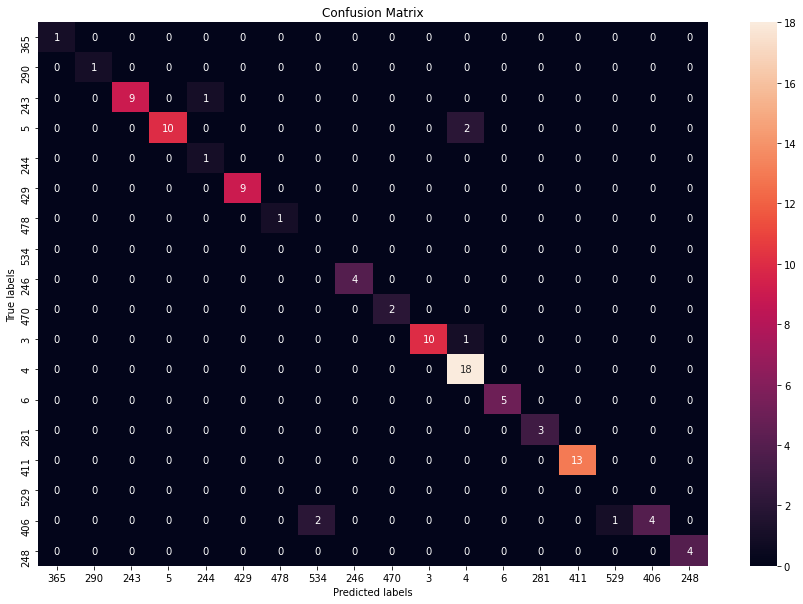


-----------------------------------------------------------------------

fold 2
              precision    recall  f1-score   support

         365       1.00      1.00      1.00         1
         290       1.00      1.00      1.00         1
         243       1.00      0.90      0.95        10
           5       1.00      0.92      0.96        12
         244       0.00      0.00      0.00         1
         429       1.00      1.00      1.00         9
         478       1.00      1.00      1.00         1
         250       0.00      0.00      0.00         0
         246       1.00      1.00      1.00         4
         470       1.00      1.00      1.00         2
           3       0.85      1.00      0.92        11
         408       0.00      0.00      0.00         0
           4       1.00      0.94      0.97        18
           6       1.00      1.00      1.00         5
         281       1.00      1.00      1.00         3
         411       1.00      0.85      0.92        13


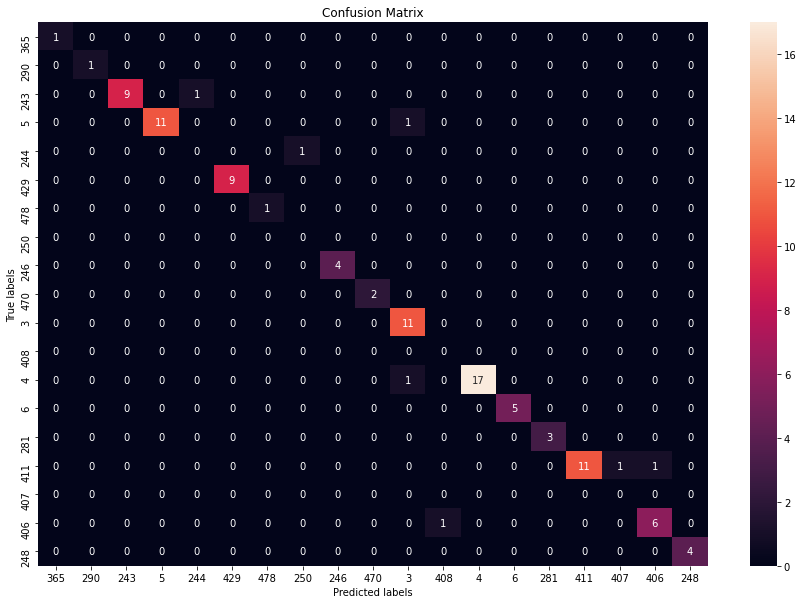


-----------------------------------------------------------------------

fold 3
              precision    recall  f1-score   support

         365       1.00      1.00      1.00         1
         290       1.00      1.00      1.00         1
         243       1.00      0.70      0.82        10
           5       1.00      0.92      0.96        12
         244       0.25      1.00      0.40         1
         429       1.00      0.89      0.94         9
         478       1.00      1.00      1.00         1
         449       0.00      0.00      0.00         0
         246       1.00      1.00      1.00         4
         470       1.00      1.00      1.00         2
           3       1.00      0.91      0.95        11
           4       0.90      1.00      0.95        18
           6       1.00      1.00      1.00         5
         281       1.00      1.00      1.00         3
         411       1.00      0.85      0.92        13
         407       0.00      0.00      0.00         0


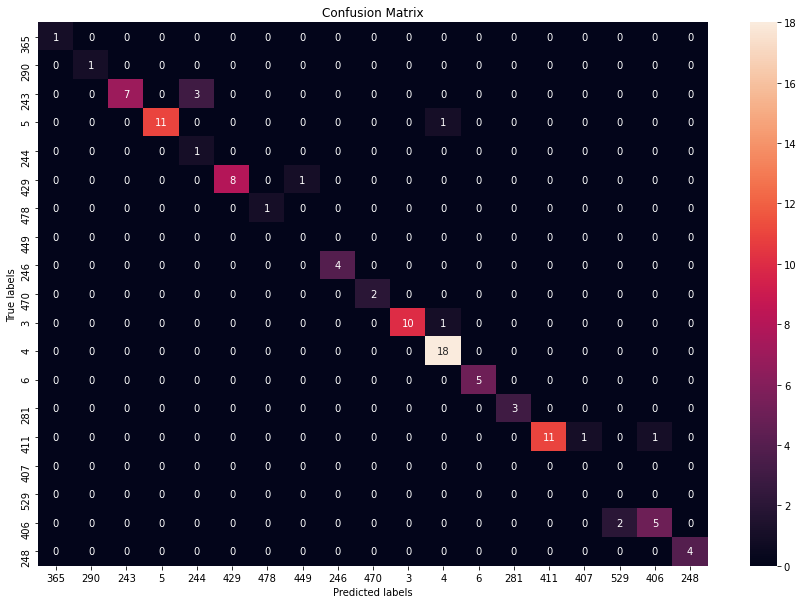


-----------------------------------------------------------------------

fold 4
              precision    recall  f1-score   support

         365       1.00      1.00      1.00         1
         290       1.00      1.00      1.00         1
         243       1.00      0.90      0.95        10
           5       1.00      0.83      0.91        12
         244       0.33      1.00      0.50         1
         429       1.00      1.00      1.00         9
         478       1.00      1.00      1.00         1
         250       0.00      0.00      0.00         0
         409       0.00      0.00      0.00         0
         534       0.00      0.00      0.00         0
         246       1.00      0.25      0.40         4
         470       1.00      1.00      1.00         2
           3       1.00      0.91      0.95        11
           4       1.00      0.94      0.97        18
           6       1.00      1.00      1.00         5
         281       1.00      1.00      1.00         3


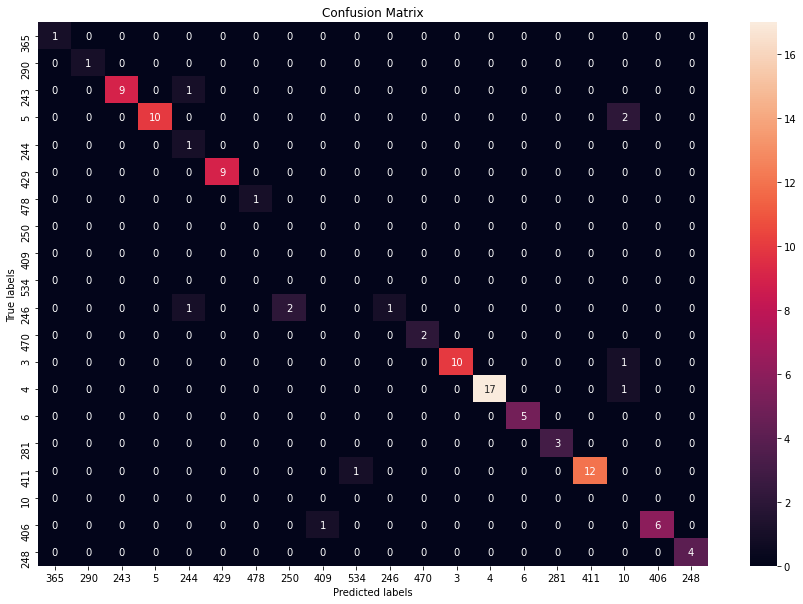


-----------------------------------------------------------------------

fold 5
              precision    recall  f1-score   support

         365       1.00      1.00      1.00         1
         290       1.00      1.00      1.00         1
         243       1.00      1.00      1.00        10
           5       1.00      0.83      0.91        12
         244       1.00      1.00      1.00         1
         429       1.00      1.00      1.00         9
         478       1.00      1.00      1.00         1
         530       0.00      0.00      0.00         0
         246       1.00      1.00      1.00         4
         470       1.00      1.00      1.00         2
           3       1.00      0.91      0.95        11
           4       0.86      1.00      0.92        18
           6       1.00      1.00      1.00         5
         281       1.00      1.00      1.00         3
         411       1.00      0.92      0.96        13
         406       1.00      1.00      1.00         7


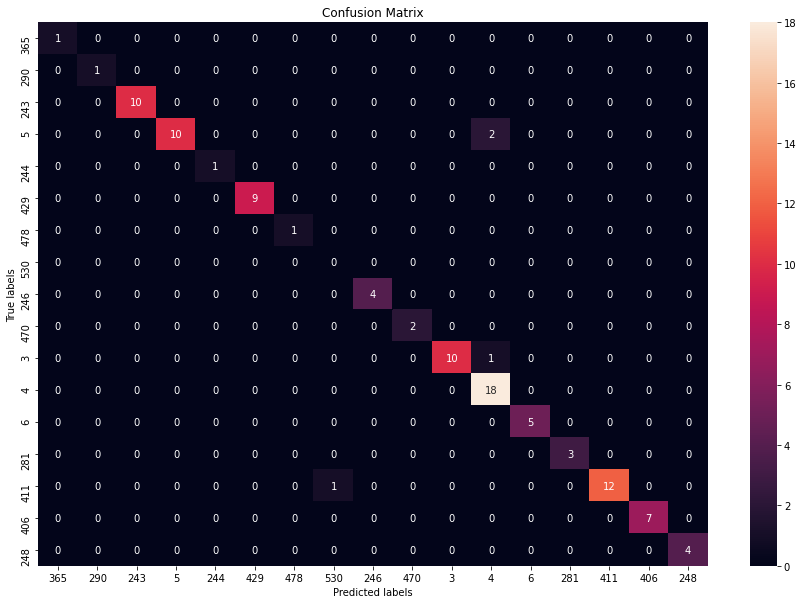


-----------------------------------------------------------------------

fold 6
              precision    recall  f1-score   support

         365       1.00      1.00      1.00         1
         290       1.00      1.00      1.00         1
         243       0.91      1.00      0.95        10
           5       1.00      0.83      0.91        12
         244       1.00      1.00      1.00         1
         429       1.00      0.89      0.94         9
         478       1.00      1.00      1.00         1
         250       0.00      0.00      0.00         0
         246       1.00      0.50      0.67         4
         470       1.00      1.00      1.00         2
           3       1.00      0.91      0.95        11
           4       0.86      1.00      0.92        18
           6       1.00      1.00      1.00         5
         281       1.00      1.00      1.00         3
         411       1.00      0.92      0.96        13
         407       0.00      0.00      0.00         0


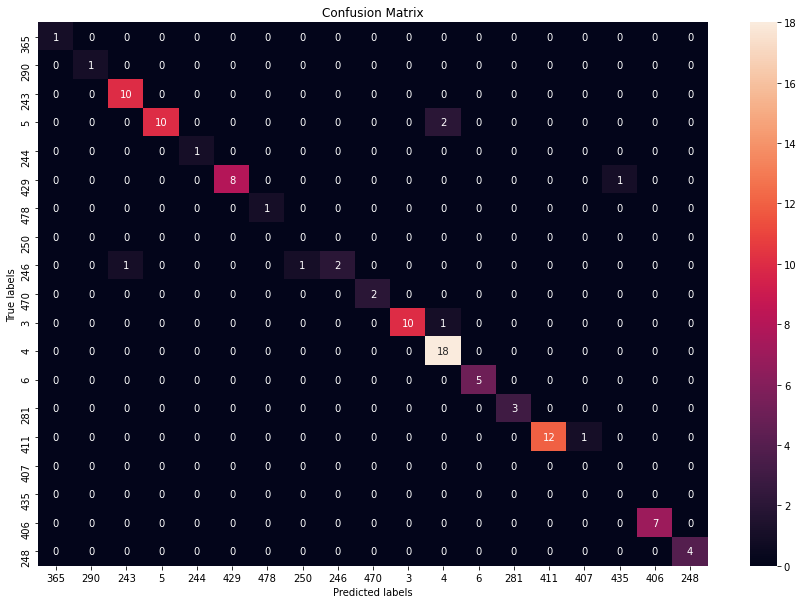


-----------------------------------------------------------------------

fold 7
              precision    recall  f1-score   support

         365       1.00      1.00      1.00         1
         290       1.00      1.00      1.00         1
         243       1.00      1.00      1.00        10
           5       1.00      0.92      0.96        12
         244       1.00      1.00      1.00         1
         429       1.00      1.00      1.00         9
         478       1.00      1.00      1.00         1
         534       0.00      0.00      0.00         0
         246       1.00      1.00      1.00         4
         470       1.00      1.00      1.00         2
           3       0.85      1.00      0.92        11
           4       1.00      0.94      0.97        18
           6       1.00      1.00      1.00         5
         281       1.00      1.00      1.00         3
         411       1.00      0.92      0.96        13
         406       0.86      0.86      0.86         7


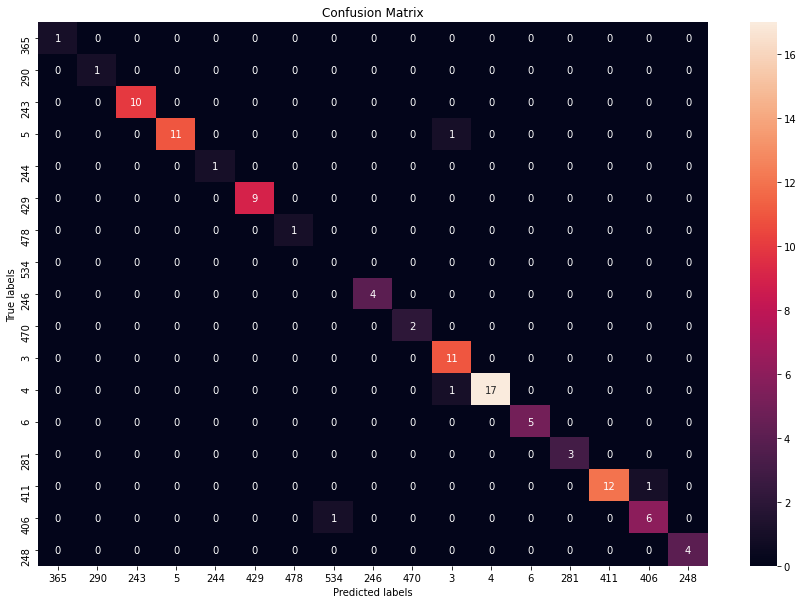


-----------------------------------------------------------------------

fold 8
              precision    recall  f1-score   support

         243       0.91      1.00      0.95        10
         246       1.00      1.00      1.00         4
         408       0.00      0.00      0.00         0
         406       1.00      0.71      0.83         7
           5       1.00      0.92      0.96        12
         244       0.00      0.00      0.00         1
         367       0.00      0.00      0.00         0
           4       1.00      0.94      0.97        18
         411       1.00      0.85      0.92        13
         365       0.00      0.00      0.00         1
         429       1.00      1.00      1.00         9
           3       0.85      1.00      0.92        11
         469       0.00      0.00      0.00         0
         529       0.00      0.00      0.00         0
         537       0.00      0.00      0.00         0
         290       1.00      1.00      1.00         1


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


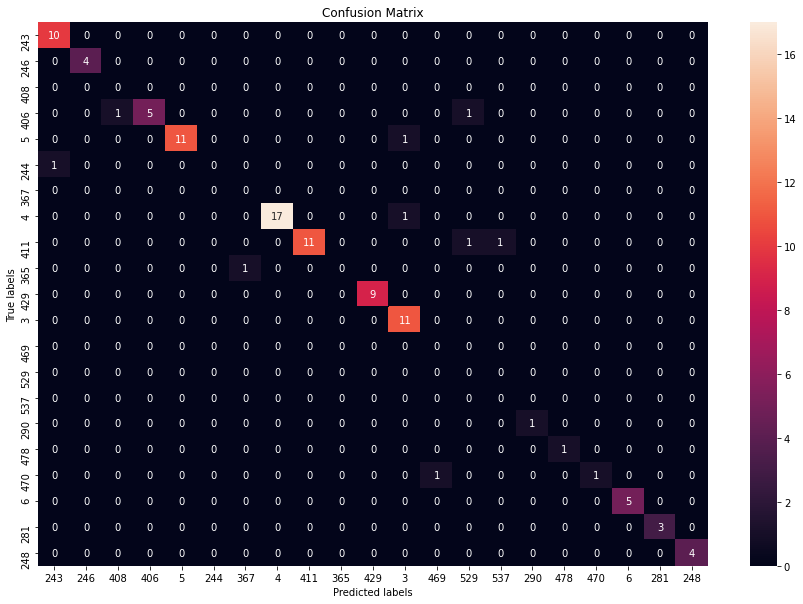


-----------------------------------------------------------------------

fold 9
              precision    recall  f1-score   support

         365       0.00      0.00      0.00         1
         290       1.00      1.00      1.00         1
         243       1.00      1.00      1.00        10
           5       0.92      1.00      0.96        12
         244       1.00      1.00      1.00         1
         429       1.00      1.00      1.00         9
         478       1.00      1.00      1.00         1
         534       0.00      0.00      0.00         0
         246       1.00      1.00      1.00         4
         470       1.00      1.00      1.00         2
           3       1.00      1.00      1.00        11
         367       0.00      0.00      0.00         0
           4       1.00      0.94      0.97        18
           6       1.00      1.00      1.00         5
         281       1.00      1.00      1.00         3
         411       1.00      0.69      0.82        13


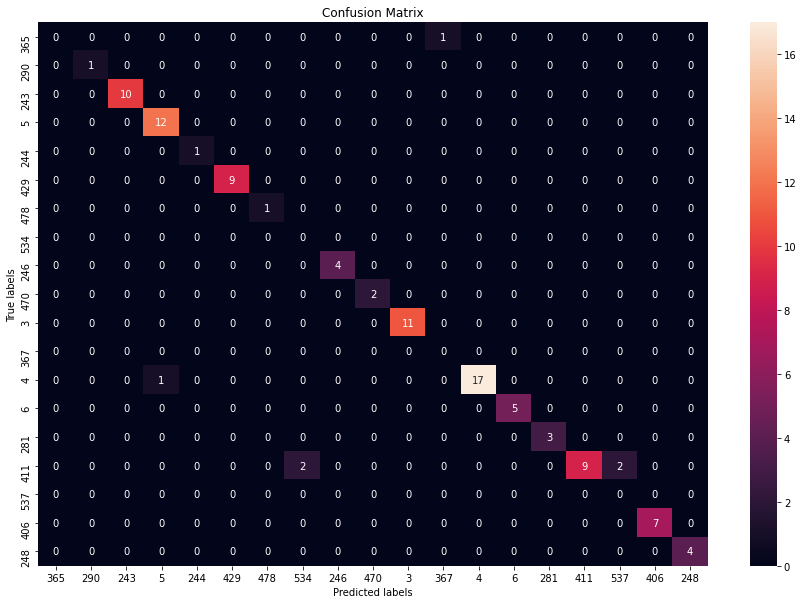


-----------------------------------------------------------------------

fold 10
              precision    recall  f1-score   support

         365       1.00      1.00      1.00         1
         290       1.00      1.00      1.00         1
         243       1.00      1.00      1.00        10
           5       0.92      1.00      0.96        12
         244       0.50      1.00      0.67         1
         429       1.00      1.00      1.00         9
         478       1.00      1.00      1.00         1
         246       1.00      0.75      0.86         4
         470       1.00      1.00      1.00         2
           3       1.00      0.91      0.95        11
           4       1.00      1.00      1.00        18
           6       1.00      1.00      1.00         5
         281       1.00      1.00      1.00         3
         411       1.00      0.85      0.92        13
         407       0.00      0.00      0.00         0
         406       1.00      0.86      0.92         7

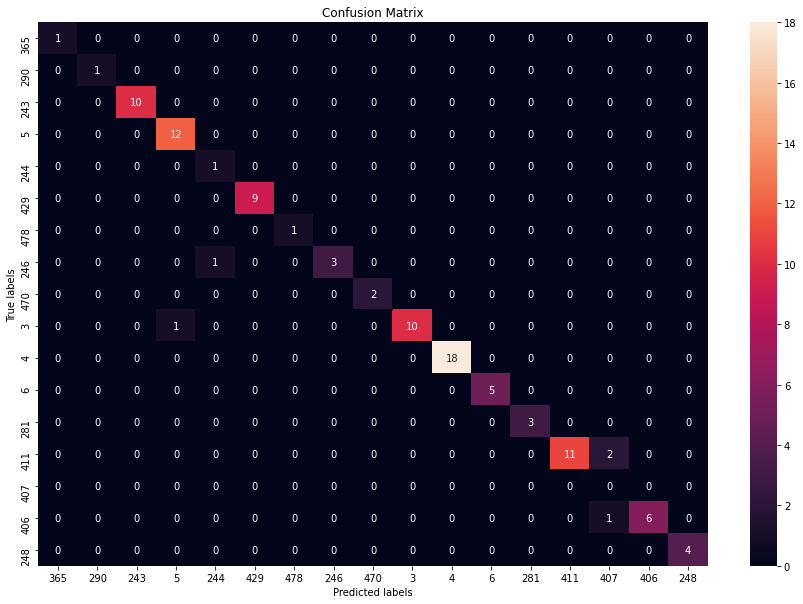


-----------------------------------------------------------------------



In [192]:
for i,p in enumerate(pred):
  print('fold', i + 1)
  print(classification_report(p[0],p[1], digits = 2,labels=list(set(p[0] +p[1] ))))
  confusion_matrix_heatmap(p[0],p[1], labels = list(set(p[0] +p[1])))
  print('\n-----------------------------------------------------------------------\n')

In [194]:
df_labels.loc[406:412]

,canonical_vendor_name,canonical_line_item_name
406,Westmont Associates,Hourly Services: LM
407,Westmont Associates,Hourly Services: KM
408,Westmont Associates,Hourly Services: CC
409,Westmont Associates,Hourly Services: SR
410,Westmont Associates,Hourly Services: KGL
411,Westmont Associates,Expenses: Filing Fees
412,Westmont Associates,Expenses: UPS Fees


We can see from the report and graphs above that overall, the model has done very well on the test set. Especially with the weighted averages, where we see that some data only has one or two values for a class and others have a frequency of 10-15. 
The parts where the model struggles I notice is when the `canonical_line_item_name` is very similar. An example is in the dataframe above where it must choose between 'Hourly Services: LM' and 'Hourly Services: KM' which is pretty difficult. 

Of course, the good looking graphs does not mean that the model actually performs well on *all* the classes, because each test set only consists of ~19 classes when there are over 70 to choose from. But due to the very small dataset, we can't really test on all of them. But we do know that the ones we do test do a descent job.




## Predict for Eval Set

this time we train on the entire dataset as we need every sample we can get

In [204]:
print('building model...')
nlp_blank, train_dataset = build_model(kb, train_data, NAME)
print('training...')
train(nlp_blank, train_dataset, epochs=600, verbose=True)


building model...
setting up
training...
0 Losses {'entity_linker': 35.18077535927296}
1 Losses {'entity_linker': 22.61160258948803}
2 Losses {'entity_linker': 18.179152965545654}
3 Losses {'entity_linker': 15.435793548822403}
4 Losses {'entity_linker': 13.709032863378525}
5 Losses {'entity_linker': 12.335747435688972}
6 Losses {'entity_linker': 11.630701318383217}
7 Losses {'entity_linker': 10.828714743256569}
8 Losses {'entity_linker': 10.138054355978966}
9 Losses {'entity_linker': 9.637061133980751}
10 Losses {'entity_linker': 9.091612711548805}
11 Losses {'entity_linker': 8.797158196568489}
12 Losses {'entity_linker': 8.448209524154663}
13 Losses {'entity_linker': 8.329036086797714}
14 Losses {'entity_linker': 8.110786154866219}
15 Losses {'entity_linker': 7.760155811905861}
16 Losses {'entity_linker': 7.789368361234665}
17 Losses {'entity_linker': 7.434273287653923}
18 Losses {'entity_linker': 7.167432188987732}
19 Losses {'entity_linker': 7.129140987992287}
20 Losses {'entity_lin

In [217]:
def format_data_eval(NAME, df):
  data = []
  for i, row in df[df.canonical_vendor_name.isin(NAME)].iterrows():
      desc = str(row.line_item_description) if not row.line_item_description is np.nan else ''
      text = row.canonical_vendor_name + ' : ' + str(row.line_item_name) + ' : '+ desc
      data.append(text)
  return data

In [262]:
def predict_eval(model, eval_dataset, df_orig=None, ):
  y_pred, y_pred_ones = [], []
    #as described before, this bit of code manually
    #predicts any vendor that has just one canonical name
  ones = df_orig[df_orig.canonical_vendor_name.isin(one_or_less)]
  map_ = one_or_less_map(one_or_less)
  for i, row in ones.iterrows():
    pred = map_[row.canonical_vendor_name]
    y_pred_ones.append(pred)
    

  for i,text in enumerate(eval_dataset):
    doc = model(text) 
    for ent in doc.ents:
        #print(f"Prediction {i}: {ent.text}, {ent.label_}, {ent.kb_id_}")
        y_pred.append(ent.kb_id_)
        break

  return y_pred, y_pred_ones

In [274]:
eval_dataset = format_data_eval(two_or_more, eval_df)
y_pred, y_pred_ones = predict_eval(nlp_blank, eval_dataset, df_orig=eval_df)
y_pred_ones = [df_labels.loc[p].canonical_line_item_name for p in y_pred_ones]
y_pred = [df_labels.loc[int(p)].canonical_line_item_name for p in y_pred]


In [ ]:
ones_eval = eval_df[eval_df.canonical_vendor_name.isin(one_or_less)]
ones_eval['canonical_line_item_name'] =y_pred_ones

twos_eval = eval_df[eval_df.canonical_vendor_name.isin(two_or_more)]
twos_eval['canonical_line_item_name'] =y_pred

In [282]:
final_df = ones_eval.append(twos_eval, verify_integrity=True).sort_index()
final_df

,line_item_name,line_item_description,canonical_vendor_name,canonical_line_item_name
0,Management Services,May 2019 Services,10 Minute Ventures,Management Services
1,Acrobat Pro DC,NaN,Adobe,Acrobat Pro DC
2,AIEX 96 Pieces Adhesive Poster Tacky Putty Sti...,NaN,Amazon Business,Pilot G2 Retractable Premium Gel Ink Roller Ba...
3,AmazonBasics AAA 1.5 Volt Performance Alkaline...,NaN,Amazon Business,AmazonBasics AAA 1.5 Volt Performance Alkaline...
4,AmazonBasics Mesh Trash Can Waste Basket,1,Amazon Business,SimpleHouseware Stackable 2 Tier Sliding Baske...
...,...,...,...,...
332,Web,1. Thimble Monthly Webapp 2. Customer Referral...,Xiamen ZhiZhi Tech,Web: Carter
333,Sam Web,1. Web app 2.0 mobile version 2. Purchase wid...,Xiamen ZhiZhi Tech,Web: Sam
334,Sam Web,1. Segment Integration 2. Iterable Integration,Xiamen ZhiZhi Tech,Web: Sam
335,Sam Web,1. Broker Purchase Project 2. New Insurance Pr...,Xiamen ZhiZhi Tech,Web: Sam


In [289]:
for i,row in final_df.iterrows():
    cand = df_labels[df_labels.canonical_vendor_name == row.canonical_vendor_name]
    assert((cand.canonical_line_item_name.eq(row.canonical_line_item_name)).any())
  

having asserted that the final data frame makes sense in terms of having the correct candidates per vendor, I can finally submit it!

In [290]:
final_df.to_csv('Yonah_Taurog_Glean_eval_tab.csv')

####other ideas

- For much of the data, I see that `canonical_line_item_name` and `line_item_name` share many similar words. So one could use more basic word embeddings, and find the canonical item with a close distance. 

- Try different word embeddings. BoW is useful for what I mentioned above. In invoices, we're not dealing with complex sentences, but rather kind of just lists and BoW or TF_IDF are strong in that regard.

- preprocessing words differently: Purposely kept words as is because since these items are very list like, capital letters and special punctuations can have an effect on the outcome. But also worth trying to remove them